In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/rohan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/rohan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
book_filenames = sorted(glob.glob("data3/*.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


['data3/file.txt']

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data3/file.txt'...
Corpus is now 555064 characters long



In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 104,419 tokens


In [16]:
num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1

In [17]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
thrones2vec.build_vocab(sentences)

2017-05-04 11:39:18,394 : INFO : collecting all words and their counts
2017-05-04 11:39:18,396 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-04 11:39:18,438 : INFO : collected 8847 word types from a corpus of 104419 raw words and 7358 sentences
2017-05-04 11:39:18,439 : INFO : Loading a fresh vocabulary
2017-05-04 11:39:18,459 : INFO : min_count=3 retains 3562 unique words (40% of original 8847, drops 5285)
2017-05-04 11:39:18,461 : INFO : min_count=3 leaves 97642 word corpus (93% of original 104419, drops 6777)
2017-05-04 11:39:18,485 : INFO : deleting the raw counts dictionary of 8847 items
2017-05-04 11:39:18,487 : INFO : sample=0.001 downsamples 49 most-common words
2017-05-04 11:39:18,488 : INFO : downsampling leaves estimated 74023 word corpus (75.8% of prior 97642)
2017-05-04 11:39:18,489 : INFO : estimated required memory for 3562 words and 300 dimensions: 10329800 bytes
2017-05-04 11:39:18,506 : INFO : resetting layer weights


In [19]:
print("Word2Vec vocabulary length:", len(thrones2vec.vocab))

2017-05-04 11:39:18,616 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab


Word2Vec vocabulary length: 3562


In [20]:
thrones2vec.train(sentences)

2017-05-04 11:39:18,702 : INFO : training model with 4 workers on 3562 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-05-04 11:39:18,703 : INFO : expecting 7358 sentences, matching count from corpus used for vocabulary survey
2017-05-04 11:39:19,947 : INFO : PROGRESS: at 9.56% examples, 28733 words/s, in_qsize 7, out_qsize 0
2017-05-04 11:39:21,265 : INFO : PROGRESS: at 24.81% examples, 36073 words/s, in_qsize 7, out_qsize 0
2017-05-04 11:39:22,467 : INFO : PROGRESS: at 40.19% examples, 39608 words/s, in_qsize 7, out_qsize 0
2017-05-04 11:39:23,499 : INFO : PROGRESS: at 53.38% examples, 41384 words/s, in_qsize 7, out_qsize 0
2017-05-04 11:39:24,592 : INFO : PROGRESS: at 65.04% examples, 40920 words/s, in_qsize 7, out_qsize 0
2017-05-04 11:39:25,863 : INFO : PROGRESS: at 80.12% examples, 41553 words/s, in_qsize 7, out_qsize 0
2017-05-04 11:39:26,881 : INFO : PROGRESS: at 94.06% examples, 42666 words/s, in_qsize 3, out_qsize 1
2017-05-04 11:39:26,888 :

369838

In [21]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2017-05-04 11:39:27,196 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2017-05-04 11:39:27,198 : INFO : not storing attribute syn0norm
2017-05-04 11:39:27,200 : INFO : not storing attribute cum_table
2017-05-04 11:39:27,423 : INFO : saved trained/thrones2vec.w2v


In [23]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2017-05-04 11:39:27,430 : INFO : loading Word2Vec object from trained/thrones2vec.w2v
2017-05-04 11:39:27,510 : INFO : loading wv recursively from trained/thrones2vec.w2v.wv.* with mmap=None
2017-05-04 11:39:27,511 : INFO : setting ignored attribute syn0norm to None
2017-05-04 11:39:27,512 : INFO : setting ignored attribute cum_table to None
2017-05-04 11:39:27,513 : INFO : loaded trained/thrones2vec.w2v


In [24]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [25]:
all_word_vectors_matrix = thrones2vec.syn0

2017-05-04 11:39:27,716 : WARNING : direct access to syn0 will not be supported in future gensim releases, please use model.wv.syn0


In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [27]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.vocab[word].index])
            for word in thrones2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

2017-05-04 11:40:19,921 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:19,922 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:19,925 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:19,926 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:19,928 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:19,929 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:19,931 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:19,931 : WARNING : direct access to vocab wil

In [28]:
sns.set_context("poster")

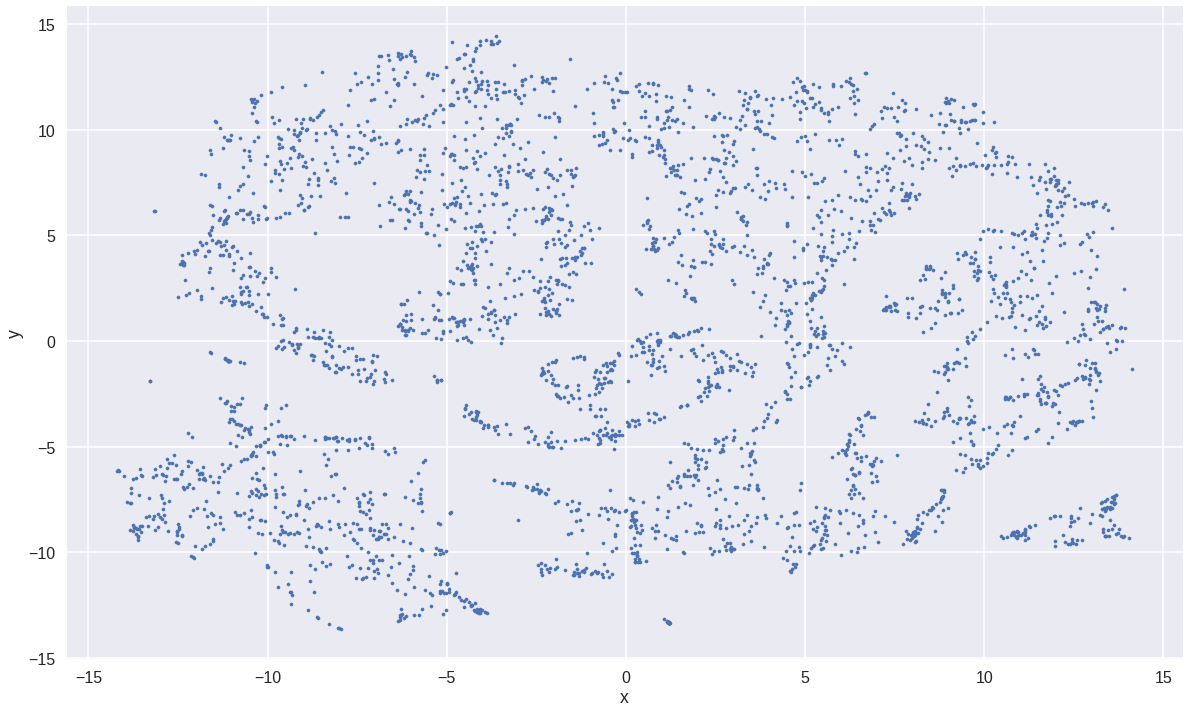

In [29]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [30]:
thrones2vec.most_similar("Stark")

2017-05-04 11:40:25,791 : INFO : precomputing L2-norms of word weight vectors


[('Joffrey', 0.9945029020309448),
 ('Robb', 0.9944971799850464),
 ('bastard', 0.9884939193725586),
 ('queen', 0.9881659746170044),
 ('name', 0.9879264831542969),
 ('Renly', 0.9875651597976685),
 ('Hand', 0.9874881505966187),
 ('commanded', 0.9868390560150146),
 ('very', 0.9861180782318115),
 ('heir', 0.9856001138687134)]

In [31]:
thrones2vec.most_similar("red")

[('steel', 0.9916790723800659),
 ('black', 0.9908240437507629),
 ('grey', 0.990100085735321),
 ('hair', 0.9893953800201416),
 ('leather', 0.989260733127594),
 ('green', 0.9879629015922546),
 ('blue', 0.9874357581138611),
 ('tall', 0.9870970249176025),
 ('stone', 0.98630690574646),
 ('white', 0.9857534170150757)]

In [32]:
thrones2vec.most_similar("house")

[('crooked', 0.999431312084198),
 ('Myr', 0.9994184374809265),
 ('shields', 0.9994149804115295),
 ('fine', 0.9994125962257385),
 ('fortress', 0.9994074702262878),
 ('risen', 0.9994060397148132),
 ('milk', 0.999353289604187),
 ('roof', 0.9993401765823364),
 ('remained', 0.9993078112602234),
 ('glimpse', 0.9993077516555786)]

In [33]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [34]:
nearest_similarity_cosmul("cup", "drink", "plate")

cup is related to drink, as fingers is related to plate


'fingers'

In [35]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

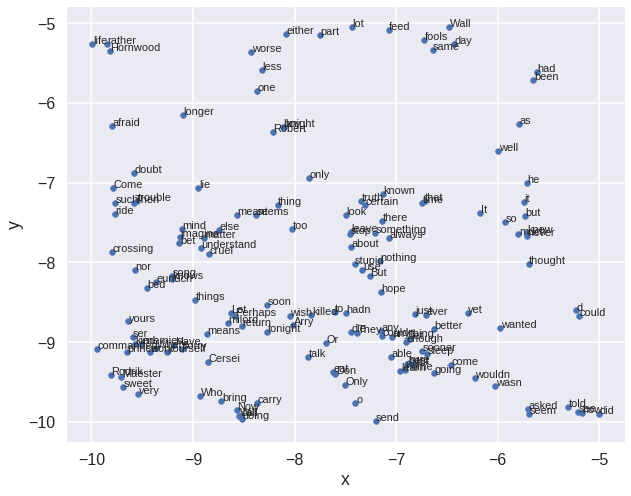

In [36]:
plot_region(x_bounds=(-10.0, -5.0), y_bounds=(-10.0, -5.0))

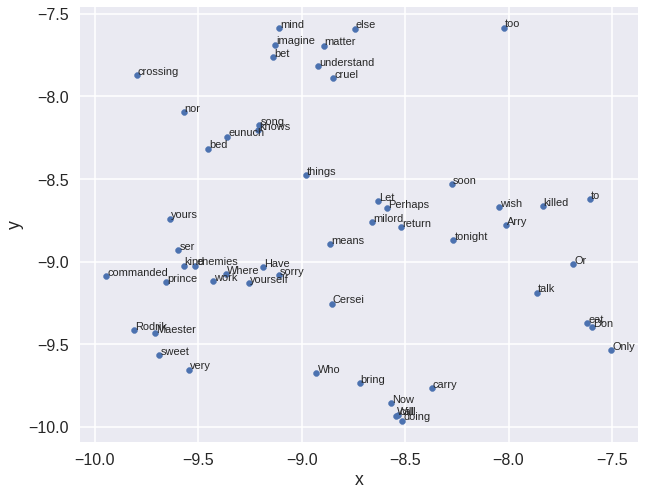

In [37]:
plot_region(x_bounds=(-10.0, -7.5), y_bounds=(-10.0, -7.5))

In [38]:
n_points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.vocab[word].index])
            for word in thrones2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

2017-05-04 11:40:27,639 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:27,641 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:27,643 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:27,644 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:27,645 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:27,647 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:27,648 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2017-05-04 11:40:27,649 : WARNING : direct access to vocab wil

In [39]:
head_size=20
sm_points = n_points.head(head_size)

In [40]:
x_list=[]
y_list=[]
w_list=[]

def fx(row):
    return row['x']

def fy(row):
    return row['y']


def fw(row):
    return row['word']

In [41]:
for k in range(0,head_size-1):
    x_list.append(fx(sm_points)[k])
    y_list.append(fy(sm_points)[k])
    w_list.append(fw(sm_points)[k])

In [42]:
x_list

[-6.7323849167334586,
 10.623844999073681,
 -9.5882895922943288,
 -8.6750912670297033,
 -11.609085216432154,
 8.8280531132219213,
 -4.5189925763587633,
 -9.8437042832382584,
 -7.8009114385863914,
 -8.6167166913913906,
 -5.776075570824438,
 -7.9787454681985723,
 -7.2367171143613804,
 -0.32803227134935459,
 -9.9965478300144497,
 6.6955866407511149,
 -4.2280779730106781,
 -5.3965118790651676,
 -7.7506059849320517]

In [43]:
y_list

[-1.9422253748195271,
 -9.278884134768191,
 1.0570765498822707,
 5.0999953846072534,
 -0.52167425659971056,
 2.2523972752388097,
 -3.5607116640020315,
 0.80455407789025613,
 7.0005251391434671,
 -13.06602665118567,
 -12.971911730941617,
 5.8571452135960982,
 -4.9195093305462851,
 -8.0395712060423321,
 2.2304640443507968,
 12.684697134791577,
 -3.7349388713557907,
 -12.008932120390003,
 -5.1479612976246747]

In [44]:
w_list

['his',
 'edition',
 'the',
 'of',
 'A',
 'Bantam',
 'Spectra',
 'and',
 'a',
 's',
 'are',
 'House',
 'All',
 'rights',
 'by',
 'R',
 'crest',
 'No',
 'part']

In [45]:
print(len(x_list))

19


In [46]:
print(len(y_list))

19


In [47]:
dist = 0
list_size = len(x_list)

for inx_i in range(1,list_size):
    for inx_j in range(1,list_size):
        x2 = x_list[inx_j]
        x1 = x_list[inx_i]
        y2 = y_list[inx_j]
        y1 = y_list[inx_i]
        dis = sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
        print(dis)
        dist = dist+dis

0.0
22.7015961556
24.0665975417
23.8954370292
11.6702750376
16.1865075369
22.8165794941
24.586394939
19.6097338739
16.8105873641
23.9824051448
18.38488041
11.0217744616
23.6149464521
22.3121069358
15.8529159795
16.2513075322
18.8330818628
22.7015961556
0.0
4.14477066741
2.56438473391
18.4550933426
6.85723998589
0.359171634753
6.20639201127
14.1564825409
14.5377263672
5.06273557119
6.42257517707
12.9808076037
1.24238198669
20.0091525468
7.18994300401
13.721938018
6.47144309484
24.0665975417
4.14477066741
0.0
6.34125303469
17.7332703749
9.60630016752
4.45156965587
2.09193779074
18.1661158258
18.3029538272
1.02867552469
10.122222826
15.5666825004
3.15918621809
17.1401703604
9.89100553758
17.4202320069
10.2895718666
23.8954370292
2.56438473391
6.34125303469
0.0
20.6245508065
7.71395890632
2.208042444
8.43123189526
12.8963191023
13.7489059453
7.33953026569
6.20149628377
13.5565825374
3.18975579789
22.5714256778
8.05011412415
13.059600327
6.02415087509
11.6702750376
18.4550933426
17.73327037

In [48]:
dist = dist/100
        
print(dist)

37.60177149


In [49]:
weak = []
strong = []

metric = dist/3

In [50]:
for inx_i in range(1,list_size):
    for inx_j in range(1,list_size):
        x2 = x_list[inx_j]
        x1 = x_list[inx_i]
        y2 = y_list[inx_j]
        y1 = y_list[inx_i]
        dis = sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
        if (dis>metric):
            weak.append(""+w_list[inx_j]+", "+w_list[inx_i])
        else:
            strong.append(""+w_list[inx_j]+", "+w_list[inx_i])

In [51]:
weak

['the, edition',
 'of, edition',
 'A, edition',
 'Spectra, edition',
 'and, edition',
 'a, edition',
 's, edition',
 'are, edition',
 'House, edition',
 'All, edition',
 'by, edition',
 'R, edition',
 'crest, edition',
 'No, edition',
 'part, edition',
 'edition, the',
 'Bantam, the',
 's, the',
 'are, the',
 'rights, the',
 'R, the',
 'No, the',
 'edition, of',
 'Bantam, of',
 's, of',
 'are, of',
 'rights, of',
 'R, of',
 'No, of',
 'edition, A',
 'Bantam, A',
 's, A',
 'are, A',
 'rights, A',
 'R, A',
 'No, A',
 'the, Bantam',
 'of, Bantam',
 'A, Bantam',
 'Spectra, Bantam',
 'and, Bantam',
 'a, Bantam',
 's, Bantam',
 'are, Bantam',
 'House, Bantam',
 'All, Bantam',
 'rights, Bantam',
 'by, Bantam',
 'crest, Bantam',
 'No, Bantam',
 'part, Bantam',
 'edition, Spectra',
 'Bantam, Spectra',
 'R, Spectra',
 'edition, and',
 'Bantam, and',
 's, and',
 'are, and',
 'rights, and',
 'R, and',
 'No, and',
 'edition, a',
 'Bantam, a',
 's, a',
 'are, a',
 'rights, a',
 'R, a',
 'No, a',
 'e

In [52]:
strong

['edition, edition',
 'Bantam, edition',
 'rights, edition',
 'the, the',
 'of, the',
 'A, the',
 'Spectra, the',
 'and, the',
 'a, the',
 'House, the',
 'All, the',
 'by, the',
 'crest, the',
 'part, the',
 'the, of',
 'of, of',
 'A, of',
 'Spectra, of',
 'and, of',
 'a, of',
 'House, of',
 'All, of',
 'by, of',
 'crest, of',
 'part, of',
 'the, A',
 'of, A',
 'A, A',
 'Spectra, A',
 'and, A',
 'a, A',
 'House, A',
 'All, A',
 'by, A',
 'crest, A',
 'part, A',
 'edition, Bantam',
 'Bantam, Bantam',
 'R, Bantam',
 'the, Spectra',
 'of, Spectra',
 'A, Spectra',
 'Spectra, Spectra',
 'and, Spectra',
 'a, Spectra',
 's, Spectra',
 'are, Spectra',
 'House, Spectra',
 'All, Spectra',
 'rights, Spectra',
 'by, Spectra',
 'crest, Spectra',
 'No, Spectra',
 'part, Spectra',
 'the, and',
 'of, and',
 'A, and',
 'Spectra, and',
 'and, and',
 'a, and',
 'House, and',
 'All, and',
 'by, and',
 'crest, and',
 'part, and',
 'the, a',
 'of, a',
 'A, a',
 'Spectra, a',
 'and, a',
 'a, a',
 'House, a',